# Set-up

In [103]:
import numpy as np
import importlib
import time
import sys
from tqdm import tqdm
from scipy.special import eval_legendre, legendre, spherical_jn

import hmvec as hm # needed for the halo model
from utils.my_units import *

importlib.reload(sys.modules['utils.power_spectrum_tools'])
from utils.power_spectrum_tools import *

# Computing the power spectrum

## Halo model stuff

In [172]:
################### UNITS ###################
# The units from hmvec are:
# proper radius r is always in Mpc
# comoving momentum k is always in Mpc-1
# masses m are in Msolar
# rho densities are in Msolar/Mpc^3
# No h units anywhere

#%%
# Construct the Halo Model using hmvec
# Redshift, mass, and wavenumbers ranges
zMin, zMax, nZs = 0.005, 1.9, 98   #0.005, 1.9, 100  
mMin, mMax, nMs = 1.e8, 1.e16, 102 #1e10, 1e17, 100
kMin, kMax, nKs = 1.e-4, 1.e3, 1001
ms  = np.geomspace(mMin, mMax, nMs)     
zs  = np.linspace(zMin, zMax, nZs)      
ks  = np.geomspace(1e-4, 1e3, nKs)      

hcos = hm.HaloModel(zs, ks, ms=ms, mass_function='tinker', mdef='vir')

unwise_color blue choose_dict 0 hod_params {'hod_alphasat': 1.304, 'hod_siglogM': 0.687, 'hod_lambda': 1.087, 'hod_M1pr_satdivh': 5027000000000.0, 'hod_Mmin_cendivh': 625100000000.0}


In [173]:
# Useful halo model quantities:
chis     = hcos.comoving_radial_distance(zs)
rvirs    = np.asarray([hcos.rvir(ms, zz) for zz in zs])
cs       = hcos.concentration()
Hubble   = hcos.h_of_z(zs)
nzm      = hcos.get_nzm()
biases   = hcos.get_bh()
deltav   = hcos.deltav(zs)
rhocritz = hcos.rho_critical_z(zs)
PzkLin = hcos._get_matter_power(zs, ks, nonlinear=False)

dvols  = chis**2. / Hubble
aas = aa(zs)
rs_nfw = rvirs/cs # scale radius for NFW profile
### check issue with pref in hmvec
#rhos_nfw = hm.rhoscale_nfw(ms, rvirs, cs) # scale density for NFW profile
rhos_nfw = my_rhoscale_nfw(ms, rvirs, cs) # scale density for NFW profile

In [174]:
get_j0(1000, 3.E-26*CentiMeter**3/Second, 1.E11*Hz)

1.6580045774069743

In [175]:
get_j0(20, 2.E-26*CentiMeter**3/Second, 140E6*Hz)

73853.39374237873

## Magnetic field

In [176]:
### Computing the magnetic field as a function of distance from the halo center for all halos
### This is a quite slow
xMin, xMax, nXs = 1.e-3, 10., 800

xs = np.geomspace(xMin, xMax, nXs) 
rhos = np.zeros((nZs, nMs, nXs))

rs = xs[None, None, :]*rs_nfw[:, :, None]/aas[:, None, None]
rhos = hm.rho_nfw(rs, rhos_nfw[:, :, None], rs_nfw[:, :, None])

def get_200critz(ms, cs, rhocritz, deltav):
    '''Get m200 and r200'''
    delta_rhos1 = deltav*rhocritz
    delta_rhos2 = 200.*rhocritz
    m200critz = hm.mdelta_from_mdelta(ms, cs, delta_rhos1, delta_rhos2)
    r200critz = hm.R_from_M(m200critz, rhocritz[:,None], delta=200.)
    return m200critz, r200critz

m200c, r200c = get_200critz(ms, cs, rhocritz, deltav)
#Bs = get_B_rs(rs, zs, ms, m200c, r200c, rhocritz)
Bs = 1.*np.ones(rhos.shape)
Bs_flat = 1.*np.ones(rhos.shape)  # using also a flat B field profile for comparison

In [177]:
Bs.shape

(98, 102, 800)

In [165]:
xVirs = rvirs * aas[:, None] / rs_nfw

## Monopole of the intensity from DM emissions

In [47]:
ell_s = aas[:, None]*chis[:, None]/rs_nfw
jrs = get_j_r(Bs, rhos, zs[:, None, None])
jrs_Bflat = get_j_r(Bs_flat, rhos, zs[:, None, None])

In [48]:
### Example computation of the power spectrum, using a cut on the max total luminosity of a given halo

mchi = 30
freq_radio = 140E6*Hz
sigmav = 2.E-26*CentiMeter**3/Second
j0factor = get_j0(mchi, sigmav, freq_radio)
    
integrand = (xs[None, None, :])**2 * jrs
flux_density = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand, xs, axis=2)

integrand = (xs[None, None, :])**2 * jrs_Bflat
flux_density_Bflat = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand, xs, axis=2)

In [8]:
flux_density.shape

(98, 102)

In [9]:
# integrate over z and m to get the average intensity
flux_cut = 0.005 # 5 mJy
cut_flux_density = np.heaviside(flux_cut/flux_density-1, 0)
int_over_m = np.trapz(nzm * flux_density * cut_flux_density, ms, axis=1)
avg_I = np.trapz(dvols * int_over_m, zs, axis=0)

In [10]:
freq_radio = 140E6*Hz
conv_radio = 0.5/freq_radio**2

conv_radio/Kelvin * avg_I * Jy

0.46489679117977745

In [11]:
jrs.shape, xs.shape

((98, 102, 1000), (1000,))

In [19]:
int_over_x = np.trapz( jrs, xs, axis=2)

thetaVir = rvirs / aas[:, None] / chis[:, None]
jell_0 = np.pi * thetaVir**2. * rs_nfw/aas[:, None] * int_over_x

int_over_m = np.trapz(nzm * jell_0, ms, axis=1)
avg_I = np.trapz(dvols * int_over_m, zs, axis=0)

In [20]:
freq_radio = 140E6*Hz
conv_radio = 0.5/freq_radio**2

conv_radio/Kelvin * avg_I * Jy

0.030597363195128367

In [37]:
int_over_x = np.trapz( jrs, xs, axis=2)

thetaVir = rvirs / aas[:, None] / chis[:, None]
jell_0 = np.pi * thetaVir**2. * rs_nfw/aas[:, None] * int_over_x

int_over_m = np.trapz(nzm * jell_0, ms, axis=1)
avg_I = np.trapz(dvols * int_over_m, zs, axis=0)
avg_I

34.42219028657548

In [38]:
freq_radio = 140E6*Hz
conv_radio = 0.5/freq_radio**2

conv_radio/Kelvin * avg_I * Jy

0.05727774045787073

## Power spectrum prelims

In [178]:
sub_boost = np.zeros((nZs, nMs))

for iz, zvalue in enumerate(zs):
    for im, mvalue in enumerate(ms):
        sub_boost[iz, im] = subhalo_boost(mvalue, zvalue)

In [196]:
np.max(sub_boost)

33.20183976374521

In [190]:
ell_s = aas[:, None]*chis[:, None]/rs_nfw
jrs = get_j_r(Bs, rhos, zs[:, None, None]) * sub_boost[:, :, None]
jrs_Bflat = get_j_r(Bs_flat, rhos, zs[:, None, None]) #* np.sqrt(sub_boost[:, :, None])

In [191]:
### Harmonic coefficients of the DM synchrotron emissivity, needed to compute the power spectrum

ell_list = np.concatenate( (np.arange(10, 100, 10), np.arange(100, 1e4, 100), ) )
jells = np.zeros((nZs, nMs, len(ell_list)))
jells_Bflat = np.zeros((nZs, nMs, len(ell_list)))

start_time = time.time()
for i_l, ell in enumerate(tqdm(ell_list)):
    arg_sin = (ell + 0.5)*xs[None, None, :]/ell_s[:, :, None]

    integrand = (xs[None, None, :])**2 * np.sin(arg_sin)/arg_sin * jrs
    jells[:, :, i_l] = 1/aas[:, None] * 4.*np.pi*rs_nfw/ell_s**2 * np.trapz( integrand, xs, axis=2)

    integrand = (xs[None, None, :])**2 * np.sin(arg_sin)/arg_sin * jrs_Bflat
    jells_Bflat[:, :, i_l] = 4.*np.pi*rs_nfw/ell_s**2 * np.trapz( integrand, xs, axis=2)

print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 108/108 [00:13<00:00,  8.17it/s]

--- 13.222448825836182 seconds ---


## Example for one point

In [12]:
### Example computation of the power spectrum, using a cut on the max total luminosity of a given halo

mchi = 30
freq_radio = 140E6*Hz
sigmav = 2.E-26*CentiMeter**3/Second
j0factor = get_j0(mchi, sigmav, freq_radio)
    
integrand = (xs[None, None, :])**2 * jrs
flux_density = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand, xs, axis=2)

integrand = (xs[None, None, :])**2 * jrs_Bflat
flux_density_Bflat = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand, xs, axis=2)

In [13]:
#### 1-halo term ####
# integrate over z and m to get the 1halo term
flux_cut = 0.005 # 5 mJy
cut_flux_density = np.heaviside(flux_cut/flux_density-1, 0)
int_over_m = np.trapz(nzm[:, :, None] * np.abs(jells)**2 * cut_flux_density[:, :, None], ms, axis=1)
Cell_1h = np.trapz(dvols[:, None] * int_over_m, zs, axis=0)

cut_flux_density_Bflat = np.heaviside(flux_cut/flux_density_Bflat-1, 0)
int_over_m = np.trapz(nzm[:, :, None] * np.abs(jells_Bflat)**2 * cut_flux_density_Bflat[:, :, None], ms, axis=1)
Cell_1h_Bflat = np.trapz(dvols[:, None] * int_over_m, zs, axis=0)
 
#### 2-halo term ####
# linear matter power at ((ell + 0.5)/chi, z)
Pzell  = get_fourier_to_multipole_Pkz(zs, ks, chis, ell_list, PzkLin)

# integrate over z and m to get the 2halo term
int_over_m_bias = np.trapz(nzm[:, :, None] * biases[:, :, None] * jells * cut_flux_density[:, :, None], ms, axis=1)
Cell_2h = np.trapz(dvols[:, None] * int_over_m_bias**2 * Pzell, zs, axis=0)

int_over_m_bias = np.trapz(nzm[:, :, None] * biases[:, :, None] * jells_Bflat * cut_flux_density_Bflat[:, :, None], ms, axis=1)
Cell_2h_Bflat = np.trapz(dvols[:, None] * int_over_m_bias**2 * Pzell, zs, axis=0)

In [14]:
### For LOFAR: unit conversion
TERB_140MHz = 193 * Kelvin
conv_radio = 0.5/freq_radio**2

Cell_1h_radio = ( conv_radio/Kelvin )**2 * Cell_1h * Jy**2
Cell_2h_radio = ( conv_radio/Kelvin )**2 * Cell_2h * Jy**2

Cell_1h_radio_Bflat = ( conv_radio/Kelvin )**2 * Cell_1h_Bflat * Jy**2
Cell_2h_radio_Bflat = ( conv_radio/Kelvin )**2 * Cell_2h_Bflat * Jy**2

In [15]:
### Differential Cell 1halo to compare to Marco

int_over_m = np.trapz(nzm[:, :, None] * np.abs(jells)**2 * cut_flux_density[:, :, None], ms, axis=1)
Cell_1h_diff = j0factor**2. * dvols[:, None] * int_over_m

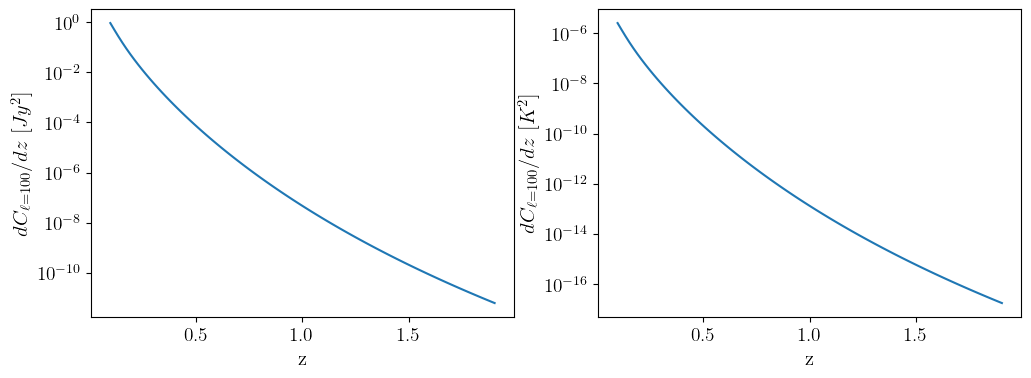

In [80]:
# Plot power spectra in the radio
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
col = sns.color_palette("deep", 4) 

ax[0].plot(zs, Cell_1h_diff[:, ell_list==100])

ax[0].set_yscale('log')
ax[0].set_xlabel(r'z', fontsize=15); ax[0].set_ylabel(r'$dC_{\ell=100}/dz\ [Jy^2]$', fontsize=15)

ax[1].plot(zs, ( conv_radio/Kelvin )**2 * Cell_1h_diff[:, ell_list==100] * Jy**2)

ax[1].set_yscale('log')
ax[1].set_xlabel(r'z', fontsize=15); ax[1].set_ylabel(r'$dC_{\ell=100}/dz\ [K^2]$', fontsize=15);

In [86]:
np.savetxt("dCelldz_100_Jysq.dat", (( conv_radio/Kelvin )**2 * Cell_1h_diff[:, ell_list==100] * Jy**2), delimiter=" ")

In [91]:
np.save("dCelldz_100_Jysq", Cell_1h_diff[:, ell_list==100])

In [92]:
test = np.load('dCelldz_100_Jysq.npy')

## Plots

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcdefaults()
from matplotlib import font_manager
from matplotlib import rcParams
import matplotlib.ticker as mticker

f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.1e'%x))
fmt = mticker.FuncFormatter(g)

rcParams['mathtext.rm'] = 'Times New Roman' 
rcParams['text.usetex'] = True
rcParams['font.family'] = 'times' #'sans-serif'
font_manager.findfont('serif', rebuild_if_missing=True)
rcParams.update({'font.size':14})

Text(3000, 2, '2h (thin)')

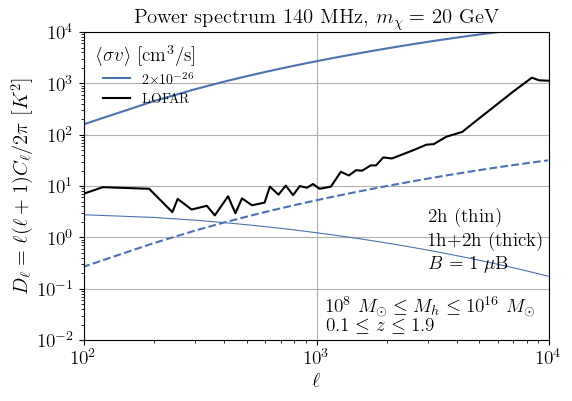

In [193]:
# Plot power spectra in the radio
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
col = sns.color_palette("deep", 4) 

mchi = 20
sigmav_list = np.array([2.E-26, 5.E-26, 1.E-25])*CentiMeter**3/Second
lofar_cells = np.loadtxt('data/LOFAR_cell.txt')
freq_radio = 140E6*Hz
conv_radio = 0.5/freq_radio**2
flux_cut = 0.005 # 5 mJy

for i, sigmav in enumerate(sigmav_list[:1]):

    mchi = 20
    j0factor = get_j0(mchi, sigmav, freq_radio)
        
    integrand = (xs[None, None, :])**2 * jrs
    flux_density = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand, xs, axis=2)
    cut_flux_density = np.ones(np.shape(flux_density_Bflat)) #np.heaviside(flux_cut/flux_density-1, 0) #

    integrand_Bflat = (xs[None, None, :])**2 * jrs_Bflat
    flux_density_Bflat = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand_Bflat, xs, axis=2)
    cut_flux_density_Bflat = np.ones(np.shape(flux_density_Bflat)) #np.heaviside(flux_cut/flux_density_Bflat-1, 0) #

    #### 1-halo term ####
    int_over_m = np.trapz(nzm[:, :, None] * np.abs(jells)**2 * cut_flux_density[:, :, None], ms, axis=1)
    Cell_1h = np.trapz(dvols[:, None] * int_over_m, zs, axis=0)
    int_over_m = np.trapz(nzm[:, :, None] * np.abs(jells_Bflat)**2 * cut_flux_density_Bflat[:, :, None], ms, axis=1)
    Cell_1h_Bflat = np.trapz(dvols[:, None] * int_over_m, zs, axis=0)
    #### 2-halo term ####
    Pzell  = get_fourier_to_multipole_Pkz(zs, ks, chis, ell_list, PzkLin)
    int_over_m_bias = np.trapz(nzm[:, :, None] * biases[:, :, None] * jells * cut_flux_density[:, :, None], ms, axis=1)
    Cell_2h = np.trapz(dvols[:, None] * int_over_m_bias**2 * Pzell, zs, axis=0)
    int_over_m_bias = np.trapz(nzm[:, :, None] * biases[:, :, None] * jells_Bflat * cut_flux_density_Bflat[:, :, None], ms, axis=1)
    Cell_2h_Bflat = np.trapz(dvols[:, None] * int_over_m_bias**2 * Pzell, zs, axis=0)

    Cell_1h_radio = ( conv_radio/Kelvin )**2 * Cell_1h * Jy**2
    Cell_2h_radio = ( conv_radio/Kelvin )**2 * Cell_2h * Jy**2
    Cell_1h_radio_Bflat = ( conv_radio/Kelvin )**2 * Cell_1h_Bflat * Jy**2
    Cell_2h_radio_Bflat = ( conv_radio/Kelvin )**2 * Cell_2h_Bflat * Jy**2

    ax.plot(ell_list, ell_list*(ell_list+1)/(2.*np.pi)*(j0factor**2)*(Cell_1h_radio + Cell_2h_radio), color=col[i], label=r'{}'.format(fmt(sigmav/(CentiMeter**3/Second))))
    ax.plot(ell_list, ell_list*(ell_list+1)/(2.*np.pi)*(j0factor**2)*(Cell_2h_radio ), color=col[i], linewidth=0.8)
    ax.plot(ell_list, ell_list*(ell_list+1)/(2.*np.pi)*(j0factor**2)*(Cell_1h_radio_Bflat + Cell_2h_radio_Bflat), color=col[i], linestyle='dashed')

ax.plot(lofar_cells[:, 0], lofar_cells[:, 1], color='k', label='LOFAR')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(100, 1e4); ax.set_ylim(1e-2, 1E4)
ax.legend(loc='upper left', ncol=1, fontsize=10, frameon=False, title=r'$\langle \sigma v \rangle\ [\mathrm{cm}^3/\mathrm{s}]$')
ax.grid()
ax.set_xlabel(r'$\ell$', fontsize=15); ax.set_ylabel(r'$D_{\ell} = \ell(\ell+1)C_{\ell}/2\pi\ [K^2]$', fontsize=15)
#ax.set_title(r'Power spectrum 140 MHz, $m_{\chi} =$ '+str(mchi)+' GeV, $S < 5$ mJy', fontsize=15);
ax.set_title(r'Power spectrum 140 MHz, $m_{\chi} =$ '+str(mchi)+' GeV', fontsize=15);
#ax.text(1500, 0.13, 'Auriga B field (solid)')
ax.text(1100, 0.015, r'$0.1 \leq z \leq 1.9$')
ax.text(1100, 0.035, r'$10^8\ M_{\odot} \leq M_{h} \leq 10^{16}\ M_{\odot}$')
ax.text(3000, 0.25, r'$B = 1\ \mu$B')
ax.text(3000, 0.7, r'1h+2h (thick)')
ax.text(3000, 2, r'2h (thin)')

#fig.savefig('figs/power_spectra_LOFAR.pdf', bbox_inches='tight')

Text(3000, 2, '2h (thin)')

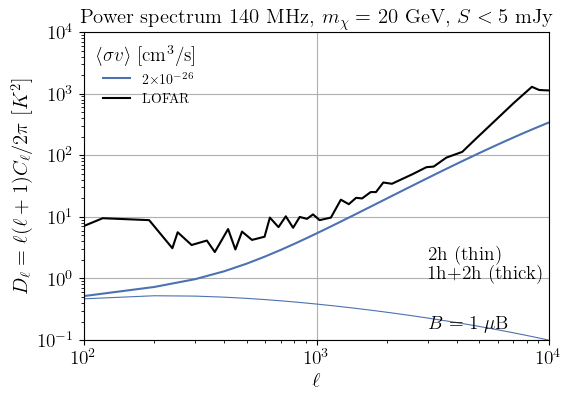

In [42]:
# Plot power spectra in the radio
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
col = sns.color_palette("deep", 4) 

mchi = 20
sigmav_list = np.array([2.E-26, 5.E-26, 1.E-25])*CentiMeter**3/Second
lofar_cells = np.loadtxt('data/LOFAR_cell.txt')
freq_radio = 140E6*Hz
conv_radio = 0.5/freq_radio**2
flux_cut = 0.005 # 5 mJy

for i, sigmav in enumerate(sigmav_list[:1]):

    mchi = 20
    j0factor = get_j0(mchi, sigmav, freq_radio)
        
    integrand = (xs[None, None, :])**2 * jrs
    flux_density = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand, xs, axis=2)
    cut_flux_density = np.heaviside(flux_cut/flux_density-1, 0) #np.ones(np.shape(flux_density_Bflat)) #

    integrand_Bflat = (xs[None, None, :])**2 * jrs_Bflat
    flux_density_Bflat = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand_Bflat, xs, axis=2)
    cut_flux_density_Bflat = np.heaviside(flux_cut/flux_density_Bflat-1, 0) #np.ones(np.shape(flux_density_Bflat)) #

    #### 1-halo term ####
    int_over_m = np.trapz(nzm[:, :, None] * np.abs(jells)**2 * cut_flux_density[:, :, None], ms, axis=1)
    Cell_1h = np.trapz(dvols[:, None] * int_over_m, zs, axis=0)
    int_over_m = np.trapz(nzm[:, :, None] * np.abs(jells_Bflat)**2 * cut_flux_density_Bflat[:, :, None], ms, axis=1)
    Cell_1h_Bflat = np.trapz(dvols[:, None] * int_over_m, zs, axis=0)
    #### 2-halo term ####
    Pzell  = get_fourier_to_multipole_Pkz(zs, ks, chis, ell_list, PzkLin)
    int_over_m_bias = np.trapz(nzm[:, :, None] * biases[:, :, None] * jells * cut_flux_density[:, :, None], ms, axis=1)
    Cell_2h = np.trapz(dvols[:, None] * int_over_m_bias**2 * Pzell, zs, axis=0)
    int_over_m_bias = np.trapz(nzm[:, :, None] * biases[:, :, None] * jells_Bflat * cut_flux_density_Bflat[:, :, None], ms, axis=1)
    Cell_2h_Bflat = np.trapz(dvols[:, None] * int_over_m_bias**2 * Pzell, zs, axis=0)

    Cell_1h_radio = ( conv_radio/Kelvin )**2 * Cell_1h * Jy**2
    Cell_2h_radio = ( conv_radio/Kelvin )**2 * Cell_2h * Jy**2
    Cell_1h_radio_Bflat = ( conv_radio/Kelvin )**2 * Cell_1h_Bflat * Jy**2
    Cell_2h_radio_Bflat = ( conv_radio/Kelvin )**2 * Cell_2h_Bflat * Jy**2

    ax.plot(ell_list, ell_list*(ell_list+1)/(2.*np.pi)*(j0factor**2)*(Cell_1h_radio + Cell_2h_radio), color=col[i], label=r'{}'.format(fmt(sigmav/(CentiMeter**3/Second))))
    ax.plot(ell_list, ell_list*(ell_list+1)/(2.*np.pi)*(j0factor**2)*(Cell_2h_radio ), color=col[i], linewidth=0.8)
    #ax.plot(ell_list, ell_list*(ell_list+1)/(2.*np.pi)*(j0factor**2)*(Cell_1h_radio_Bflat + Cell_2h_radio_Bflat), color=col[i], linestyle='dashed')

ax.plot(lofar_cells[:, 0], lofar_cells[:, 1], color='k', label='LOFAR')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(100, 1e4); ax.set_ylim(1e-1, 1E4)
ax.legend(loc='upper left', ncol=1, fontsize=10, frameon=False, title=r'$\langle \sigma v \rangle\ [\mathrm{cm}^3/\mathrm{s}]$')
ax.grid()
ax.set_xlabel(r'$\ell$', fontsize=15); ax.set_ylabel(r'$D_{\ell} = \ell(\ell+1)C_{\ell}/2\pi\ [K^2]$', fontsize=15)
ax.set_title(r'Power spectrum 140 MHz, $m_{\chi} =$ '+str(mchi)+' GeV, $S < 5$ mJy', fontsize=15);
#ax.text(1500, 0.13, 'Auriga B field (solid)')
ax.text(3000, 0.15, r'$B = 1\ \mu$B')
ax.text(3000, 1, r'1h+2h (thick)')
ax.text(3000, 2, r'2h (thin)')

#fig.savefig('figs/power_spectra_LOFAR.pdf', bbox_inches='tight')

Text(1500, 0.05, '$B = 0.1\\ \\mu$B (dashed)')

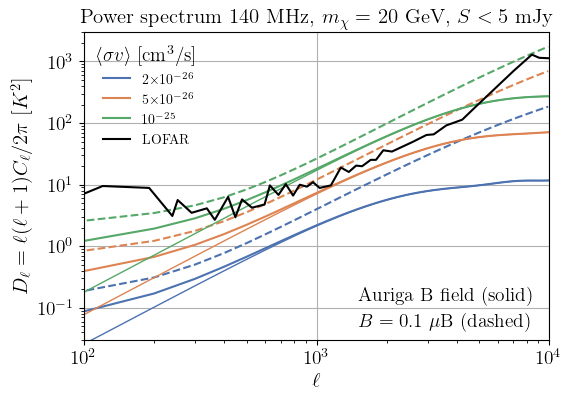

In [12]:
# Plot power spectra in the radio
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
col = sns.color_palette("deep", 4) 

mchi = 30
sigmav_list = np.array([2.E-26, 5.E-26, 1.E-25])*CentiMeter**3/Second
lofar_cells = np.loadtxt('data/LOFAR_cell.txt')
freq_radio = 140E6*Hz
conv_radio = 0.5/freq_radio**2
flux_cut = 0.005 # 5 mJy

for i, sigmav in enumerate(sigmav_list):

    mchi = 20
    j0factor = get_j0(mchi, sigmav, freq_radio)
        
    integrand = (xs[None, None, :])**2 * jrs
    flux_density = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand, xs, axis=2)
    cut_flux_density = np.heaviside(flux_cut/flux_density-1, 0)

    integrand_Bflat = (xs[None, None, :])**2 * jrs_Bflat
    flux_density_Bflat = j0factor * rs_nfw**3/(aas[:, None]**5 * chis[:, None]**2) * np.trapz( integrand_Bflat, xs, axis=2)
    cut_flux_density_Bflat = np.heaviside(flux_cut/flux_density_Bflat-1, 0)

    #### 1-halo term ####
    int_over_m = np.trapz(nzm[:, :, None] * np.abs(jells)**2 * cut_flux_density[:, :, None], ms, axis=1)
    Cell_1h = np.trapz(dvols[:, None] * int_over_m, zs, axis=0)
    int_over_m = np.trapz(nzm[:, :, None] * np.abs(jells_Bflat)**2 * cut_flux_density_Bflat[:, :, None], ms, axis=1)
    Cell_1h_Bflat = np.trapz(dvols[:, None] * int_over_m, zs, axis=0)
    #### 2-halo term ####
    Pzell  = get_fourier_to_multipole_Pkz(zs, ks, chis, ell_list, PzkLin)
    int_over_m_bias = np.trapz(nzm[:, :, None] * biases[:, :, None] * jells * cut_flux_density[:, :, None], ms, axis=1)
    Cell_2h = np.trapz(dvols[:, None] * int_over_m_bias**2 * Pzell, zs, axis=0)
    int_over_m_bias = np.trapz(nzm[:, :, None] * biases[:, :, None] * jells_Bflat * cut_flux_density_Bflat[:, :, None], ms, axis=1)
    Cell_2h_Bflat = np.trapz(dvols[:, None] * int_over_m_bias**2 * Pzell, zs, axis=0)

    Cell_1h_radio = ( conv_radio/Kelvin )**2 * Cell_1h * Jy**2
    Cell_2h_radio = ( conv_radio/Kelvin )**2 * Cell_2h * Jy**2
    Cell_1h_radio_Bflat = ( conv_radio/Kelvin )**2 * Cell_1h_Bflat * Jy**2
    Cell_2h_radio_Bflat = ( conv_radio/Kelvin )**2 * Cell_2h_Bflat * Jy**2

    ax.plot(ell_list, ell_list*(ell_list+1)/(2.*np.pi)*(j0factor**2)*(Cell_1h_radio + Cell_2h_radio), color=col[i], label=r'{}'.format(fmt(sigmav/(CentiMeter**3/Second))))
    ax.plot(ell_list, ell_list*(ell_list+1)/(2.*np.pi)*(j0factor**2)*(Cell_1h_radio ), color=col[i], linewidth=1)
    ax.plot(ell_list, ell_list*(ell_list+1)/(2.*np.pi)*(j0factor**2)*(Cell_1h_radio_Bflat + Cell_2h_radio_Bflat), color=col[i], linestyle='dashed')

ax.plot(lofar_cells[:, 0], lofar_cells[:, 1], color='k', label='LOFAR')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(100, 1e4); ax.set_ylim(3e-2, 3000)
ax.legend(loc='upper left', ncol=1, fontsize=10, frameon=False, title=r'$\langle \sigma v \rangle\ [\mathrm{cm}^3/\mathrm{s}]$')
ax.grid()
ax.set_xlabel(r'$\ell$', fontsize=15); ax.set_ylabel(r'$D_{\ell} = \ell(\ell+1)C_{\ell}/2\pi\ [K^2]$', fontsize=15)
ax.set_title(r'Power spectrum 140 MHz, $m_{\chi} =$ '+str(mchi)+' GeV, $S < 5$ mJy', fontsize=15);
ax.text(1500, 0.13, 'Auriga B field (solid)')
ax.text(1500, 0.05, r'$B = 0.1\ \mu$B (dashed)')

#fig.savefig('figs/power_spectra_LOFAR.pdf', bbox_inches='tight')

In [48]:
PzkLin.shape

(98, 1001)

In [52]:
np.argmin(np.abs(zs-1))

49

In [53]:
zs[49]

1.0092783505154639

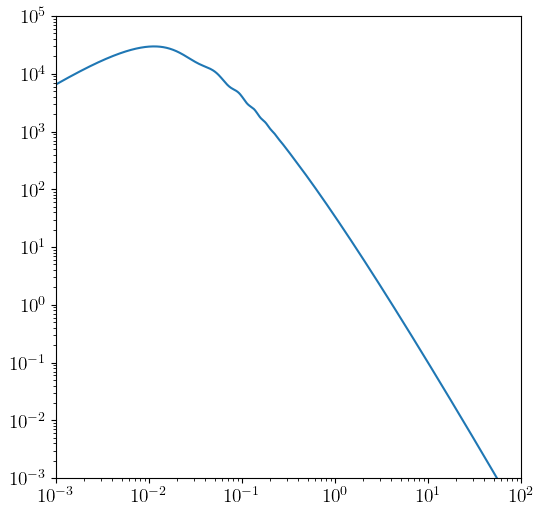

In [59]:
# Plot power spectra in the radio
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(ks, PzkLin[49, :])
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlim(1e-3, 1e2); ax.set_ylim(1e-3, 1e5)
ax.minorticks_on()